Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,roc_auc_score, roc_curve, precision_recall_curve, auc, accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [5]:
device = torch.cuda.is_available()
print(device)

True


Data Pre-Processing

In [6]:
url = "/content/shadow_robot_dataset.csv"
df = pd.read_csv(url)

In [7]:
print(df.columns)

Index(['experiment_number', ' robustness', ' H1_F1J2_pos ', ' H1_F1J2_vel ',
       ' H1_F1J2_eff ', ' H1_F1J3_pos ', ' H1_F1J3_vel ', ' H1_F1J3_eff ',
       ' H1_F1J1_pos ', ' H1_F1J1_vel ', ' H1_F1J1_eff ', ' H1_F3J1_pos ',
       ' H1_F3J1_vel ', ' H1_F3J1_eff ', ' H1_F3J2_pos ', ' H1_F3J2_vel ',
       ' H1_F3J2_eff ', ' H1_F3J3_pos ', ' H1_F3J3_vel ', ' H1_F3J3_eff ',
       ' H1_F2J1_pos ', ' H1_F2J1_vel ', ' H1_F2J1_eff ', ' H1_F2J3_pos ',
       ' H1_F2J3_vel ', ' H1_F2J3_eff ', ' H1_F2J2_pos ', ' H1_F2J2_vel ',
       ' H1_F2J2_eff ', ' measurement_number'],
      dtype='object')


In [8]:
df=df.drop(columns=['experiment_number',' measurement_number'])

In [9]:
#Data Standardization
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled.head()

,robustness,H1_F1J2_pos,H1_F1J2_vel,H1_F1J2_eff,H1_F1J3_pos,H1_F1J3_vel,H1_F1J3_eff,H1_F1J1_pos,H1_F1J1_vel,H1_F1J1_eff,...,H1_F3J3_eff,H1_F2J1_pos,H1_F2J1_vel,H1_F2J1_eff,H1_F2J3_pos,H1_F2J3_vel,H1_F2J3_eff,H1_F2J2_pos,H1_F2J2_vel,H1_F2J2_eff
0,0.165912,-0.185388,1.326969,0.836572,-0.128091,-1.276012,-0.02236,-0.636563,0.963188,-0.355450,...,0.262125,2.665953,0.361604,1.881526,0.106532,-1.748621,-0.092262,-0.346330,2.467549,1.789803
1,0.165912,0.122255,1.161634,0.496391,-0.118616,-0.961382,-0.02236,-0.509129,2.030469,-1.090873,...,0.450392,2.577937,-1.075088,3.254811,0.119192,-2.203847,-0.092262,-0.349256,2.319453,1.789408
2,0.165912,0.203933,1.025122,0.401583,-0.110828,-0.886985,-0.02236,-0.468814,1.379315,-1.344174,...,0.495833,2.528018,-1.347162,4.059495,0.106951,-1.630595,-0.092262,-0.373628,2.555901,1.831709
3,0.165912,-0.012910,1.261307,0.647162,-0.125145,-1.152664,-0.02236,-0.509578,0.918514,-1.111423,...,0.406551,2.594501,-1.543466,2.960803,0.118122,-1.472177,-0.092262,-0.310783,2.381556,1.736140
4,0.165912,0.200212,0.945907,0.401746,-0.108703,-0.928828,-0.02236,-0.465997,0.618148,-1.376733,...,0.454004,2.539884,-1.793077,3.843660,0.104930,-1.920014,-0.092262,-0.469317,2.869290,1.978731


In [10]:
df.shape

(36884, 28)

In [11]:
X=df_scaled.drop(columns=[' robustness'])
y=df_scaled[' robustness']

Exploratory Data Analysis

In [12]:
df.describe()

,robustness,H1_F1J2_pos,H1_F1J2_vel,H1_F1J2_eff,H1_F1J3_pos,H1_F1J3_vel,H1_F1J3_eff,H1_F1J1_pos,H1_F1J1_vel,H1_F1J1_eff,...,H1_F3J3_eff,H1_F2J1_pos,H1_F2J1_vel,H1_F2J1_eff,H1_F2J3_pos,H1_F2J3_vel,H1_F2J3_eff,H1_F2J2_pos,H1_F2J2_vel,H1_F2J2_eff
count,36884.000000,36884.000000,36884.000000,36884.000000,36884.000000,36884.000000,36884.000000,36884.000000,36884.000000,36884.000000,...,36883.000000,36883.000000,36883.000000,36883.000000,36883.000000,36883.000000,36883.000000,36883.000000,36883.000000,36883.000000
mean,77.375487,0.139141,0.084388,0.579112,0.391724,-0.222402,0.053930,-0.007517,-0.004962,0.063772,...,0.181194,0.000512,-0.001212,-0.005318,0.380875,0.017717,0.124156,0.212277,0.032168,0.227155
std,50.529968,0.112913,5.090131,1.045951,0.698323,14.511269,2.411934,0.039015,0.137247,0.065621,...,1.384852,0.040787,0.119960,0.024892,0.549932,8.002605,1.345702,0.101531,2.198274,0.707697
min,0.000001,-5.235941,-34.034056,-46.178372,0.192347,-56.009714,-50.000000,-0.151818,-4.070986,-0.336525,...,-30.000000,-0.132743,-0.589149,-0.207255,-10.995559,-84.429598,-30.000000,-0.084308,-116.037648,-30.000000
25%,15.270649,0.070376,-4.831153,0.000000,0.337249,-13.742933,0.000000,-0.034336,-0.053237,0.003117,...,0.000000,-0.027963,-0.043756,-0.013888,0.360643,-3.977542,0.000000,0.188430,-1.456457,-0.000292
50%,94.448475,0.109879,0.000637,0.008314,0.368579,0.002327,0.001271,-0.008757,-0.004719,0.058508,...,0.000709,-0.000306,0.000603,-0.005286,0.387133,0.007334,0.000015,0.208846,-0.001769,0.000000
75%,118.252136,0.220508,4.874969,1.432832,0.399874,12.616838,0.432088,0.019111,0.042843,0.121708,...,0.435461,0.028614,0.040646,0.000912,0.414070,3.928672,0.140807,0.234032,1.566088,0.408111
max,301.756584,4.886815,17.716020,50.000000,42.935096,100.005375,1.408972,0.110838,0.996755,0.319471,...,30.000000,0.117283,0.618192,0.171542,36.651870,1098.445524,30.000000,4.886922,14.085435,2.813117


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36884 entries, 0 to 36883
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0    robustness    36884 non-null  float64
 1    H1_F1J2_pos   36884 non-null  float64
 2    H1_F1J2_vel   36884 non-null  float64
 3    H1_F1J2_eff   36884 non-null  float64
 4    H1_F1J3_pos   36884 non-null  float64
 5    H1_F1J3_vel   36884 non-null  float64
 6    H1_F1J3_eff   36884 non-null  float64
 7    H1_F1J1_pos   36884 non-null  float64
 8    H1_F1J1_vel   36884 non-null  float64
 9    H1_F1J1_eff   36884 non-null  float64
 10   H1_F3J1_pos   36884 non-null  float64
 11   H1_F3J1_vel   36884 non-null  float64
 12   H1_F3J1_eff   36884 non-null  float64
 13   H1_F3J2_pos   36884 non-null  float64
 14   H1_F3J2_vel   36884 non-null  float64
 15   H1_F3J2_eff   36883 non-null  float64
 16   H1_F3J3_pos   36883 non-null  float64
 17   H1_F3J3_vel   36883 non-null  float64
 18   H1_F3

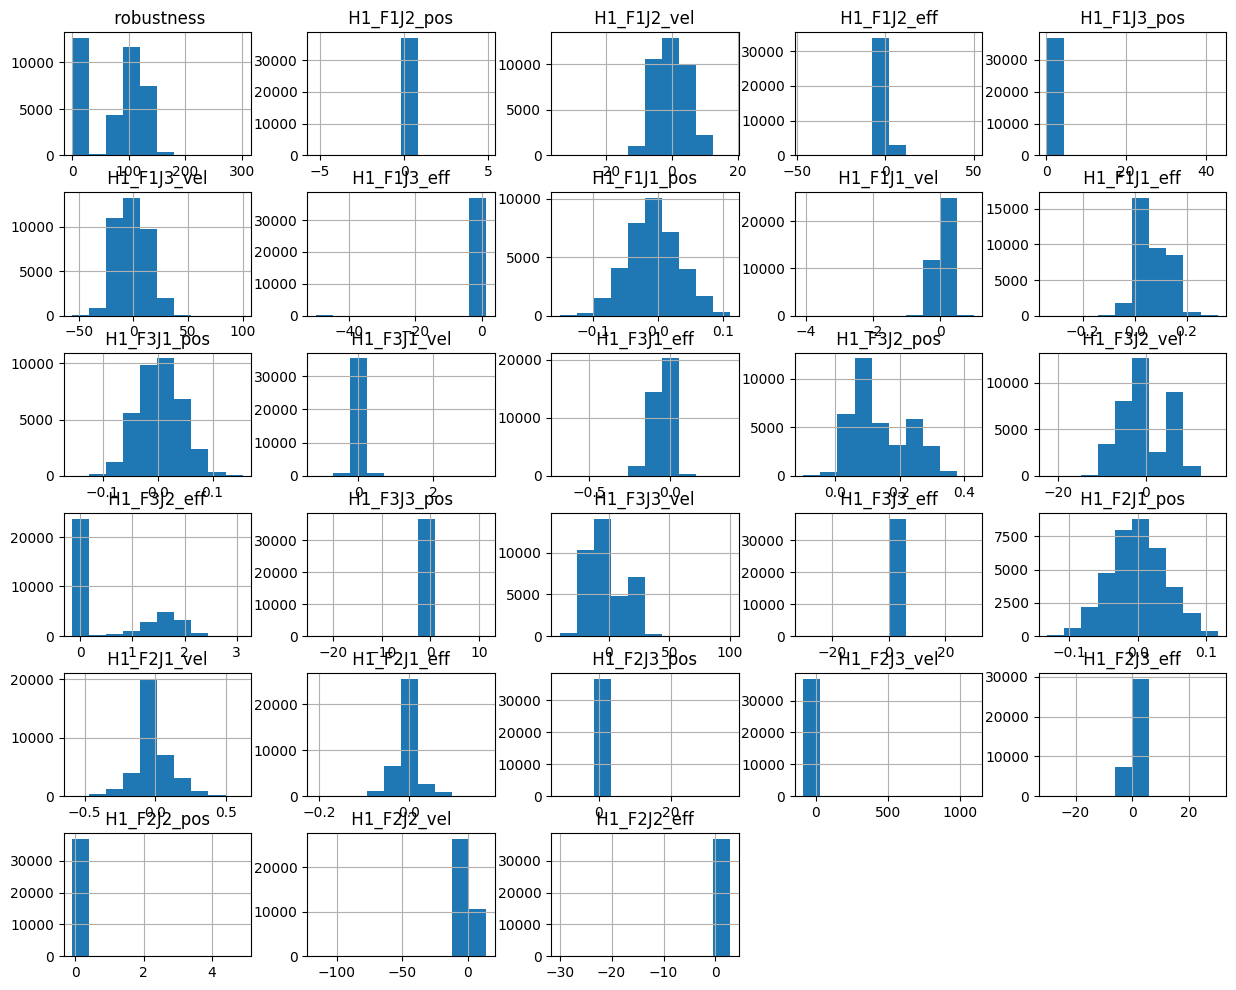

In [14]:
df.hist(figsize=(15, 12))
plt.show()

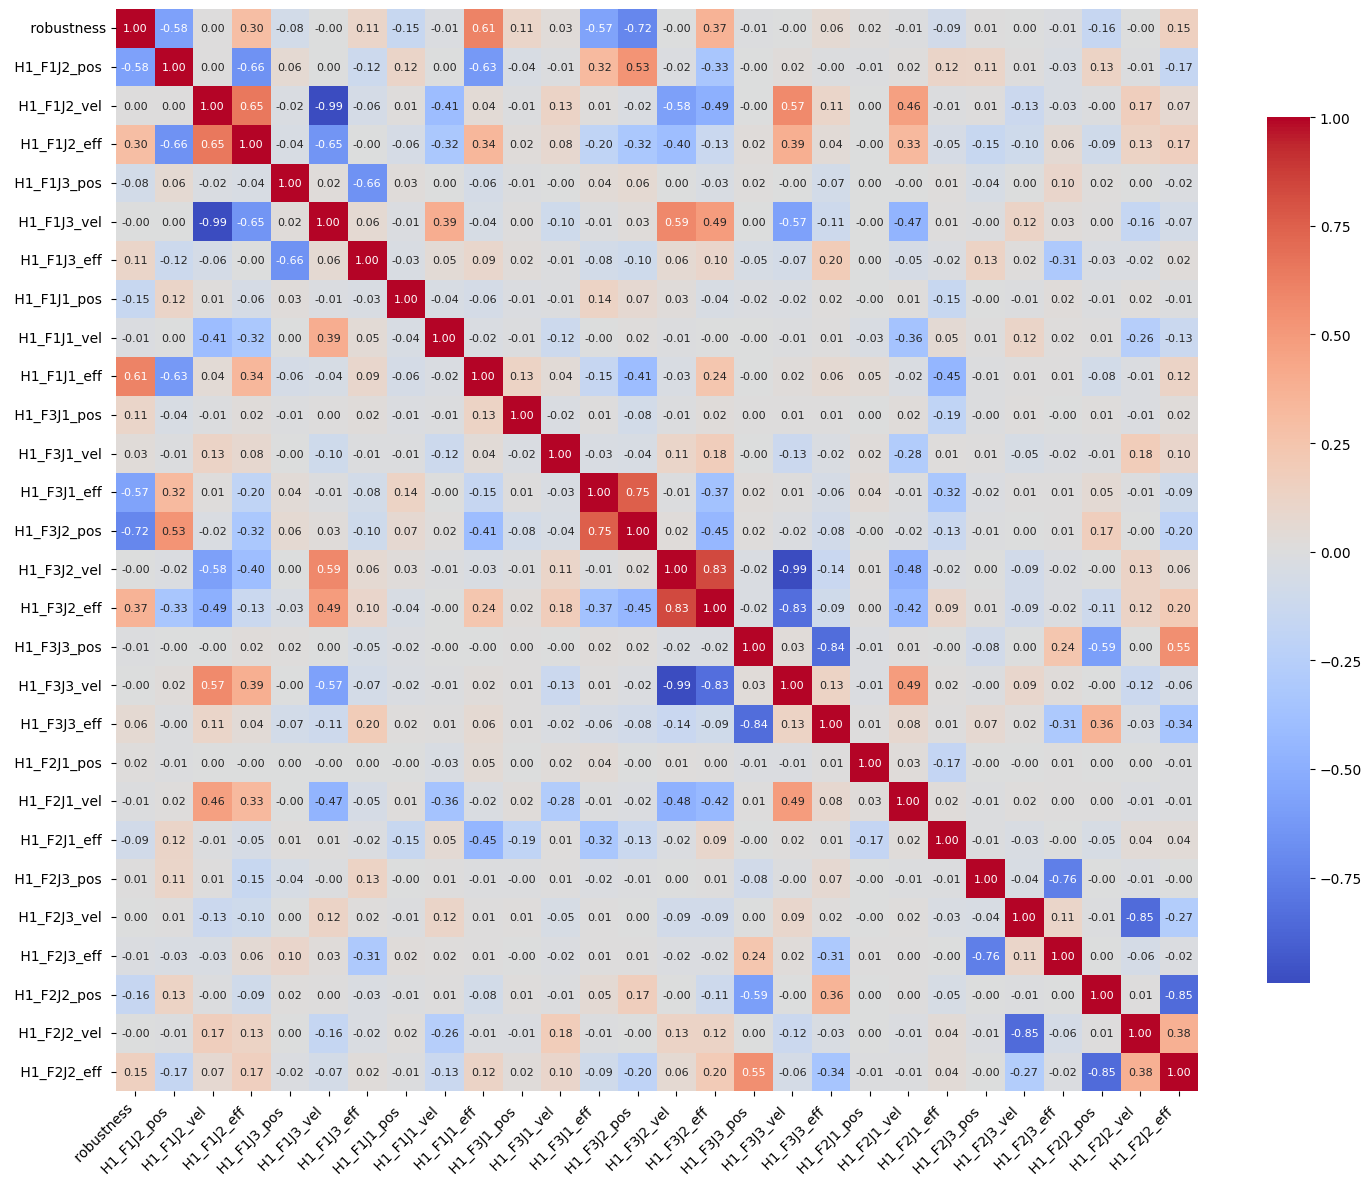

In [15]:
corr_matrix = df.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True,
            annot_kws={"size": 8},
            cbar_kws={"shrink": .8})

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

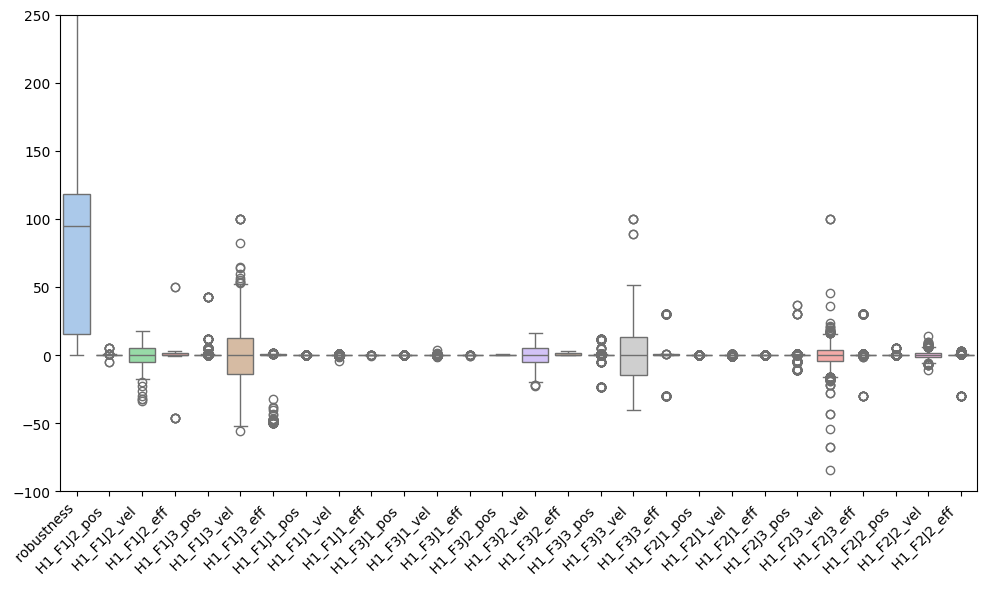

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, palette="pastel")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylim(-100, 250)
plt.tight_layout()
plt.show()

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

Handling Outliers/ Outlier Detection

In [18]:
data_train = pd.concat([y_train,X_train], axis=1)

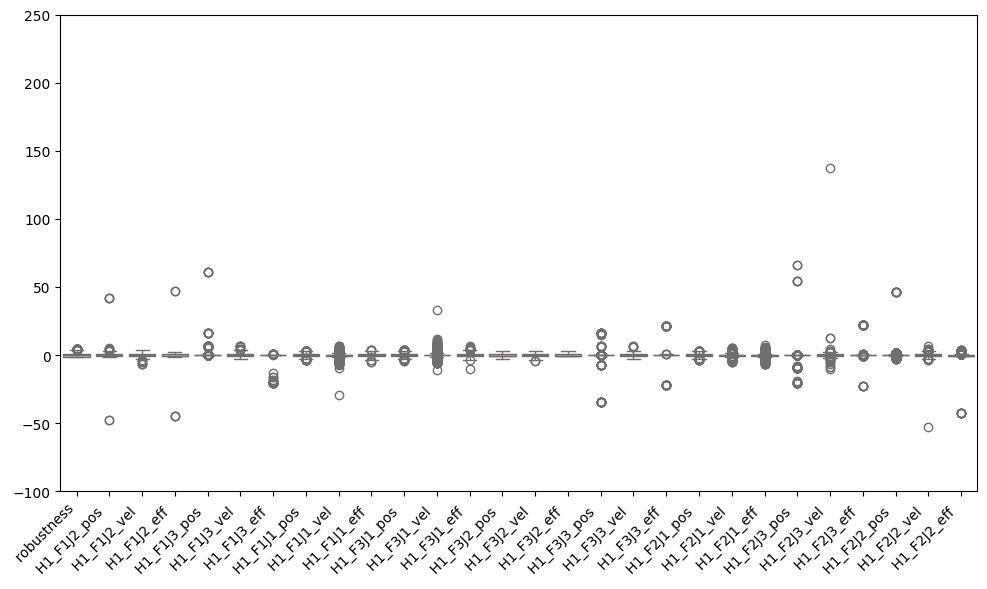

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_train, palette="pastel")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylim(-100, 250)
plt.tight_layout()
plt.show()

a) Removing Outliers


In [20]:
# Documentation
# filter_outliers function -

# Input:

# df: A pandas DataFrame containing numerical data, including features and a target column (e.g., robustness).
# k: An optional parameter (default k=3) to define the number of standard deviations used to identify outliers.
# Output:

# filtered_df: A pandas DataFrame where rows containing outliers in any column (defined as values outside the range mean ± k * std_dev) are removed.

In [21]:
def filter_outliers(df, k=3):
    filtered_df = df.copy()
    for column in df.columns:
        mean = df[column].mean()
        std_dev = df[column].std()
        upper_bound = mean + k * std_dev
        lower_bound = mean - k * std_dev

        filtered_df = filtered_df[(filtered_df[column] >= lower_bound) &
                                   (filtered_df[column] <= upper_bound)]
    return filtered_df

filtered_data = filter_outliers(data_train)
X_filtered = filtered_data.drop(columns=[' robustness'])
y_filtered = filtered_data[' robustness']

In [22]:
model = DecisionTreeRegressor(random_state=42)
model.fit(X_filtered, y_filtered)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R² Score: {r2:.4f}')

Mean Squared Error: 0.1729
R² Score: 0.8260


In [23]:
data_train.shape

(25818, 28)

In [24]:
filtered_data.shape

(23784, 28)

b) Replacing the Outliers with Mean

In [25]:
# Documentation
# replace_outliers function -

# Input:

# df: A pandas DataFrame containing the data with numerical columns.
# k: An optional parameter (default k=3) to define the number of standard deviations for identifying outliers.
# Output:

# replaced_df: A pandas DataFrame where outliers in each column are replaced by the column's mean (or median if you choose the other variant). Outliers are defined as values outside the range mean ± k * std_dev.

In [26]:
def replace_outliers(df, k=3):
    replaced_df = df.copy()
    for column in df.columns:
        mean = df[column].mean()
        std_dev = df[column].std()
        upper_bound = mean + k * std_dev
        lower_bound = mean - k * std_dev

        replaced_df[column] = replaced_df[column].where(
            (replaced_df[column] >= lower_bound) & (replaced_df[column] <= upper_bound),
            mean
        )
    return replaced_df
replaced_data = replace_outliers(data_train)

X_replaced = replaced_data.drop(columns=[' robustness'])
y_replaced = replaced_data[' robustness']

In [27]:
model = DecisionTreeRegressor(random_state=42)
model.fit(X_replaced, y_replaced)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R² Score: {r2:.4f}')

Mean Squared Error: 0.1617
R² Score: 0.8372


In [28]:
# By removing the outliers, the model is performing better than by replacing them with the mean.
# In both cases, a desicion tree regressor model is used for testing the accuracy.

In [29]:
# Overall model is performing better without handling outliers

Dimension Reduction / Feature selection

In [30]:
data_copy = df.copy()

a) From correlation matrix

In [31]:
correlated_features = {}
threshold = 0.8

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            other_colname = corr_matrix.columns[j]
            if colname not in correlated_features:
                correlated_features[colname] = []
            correlated_features[colname].append(other_colname)
print("Correlated features:", correlated_features)
to_drop = set()
for feature, others in correlated_features.items():
    target_corrs = {feature: abs(data_copy[feature].corr(data_copy[' robustness']))}
    for other in others:
        target_corrs[other] = abs(data_copy[other].corr(data_copy[' robustness']))
    print("Target correlations:", target_corrs)
    feature_to_keep = max(target_corrs, key=target_corrs.get)
    features_to_drop = [f for f in target_corrs if f != feature_to_keep]
    to_drop.update(features_to_drop)
data_reduced = data_copy.drop(columns=to_drop)

print("Features to drop:", to_drop)
print("Reduced dataset shape:", data_reduced.shape)

Correlated features: {' H1_F1J3_vel ': [' H1_F1J2_vel '], ' H1_F3J2_eff ': [' H1_F3J2_vel '], ' H1_F3J3_vel ': [' H1_F3J2_vel ', ' H1_F3J2_eff '], ' H1_F3J3_eff ': [' H1_F3J3_pos '], ' H1_F2J2_vel ': [' H1_F2J3_vel '], ' H1_F2J2_eff ': [' H1_F2J2_pos ']}
Target correlations: {' H1_F1J3_vel ': 0.0030779282405248923, ' H1_F1J2_vel ': 0.00385116377319085}
Target correlations: {' H1_F3J2_eff ': 0.3671872944825864, ' H1_F3J2_vel ': 0.00042762533202573427}
Target correlations: {' H1_F3J3_vel ': 0.001665837760663442, ' H1_F3J2_vel ': 0.00042762533202573427, ' H1_F3J2_eff ': 0.3671872944825864}
Target correlations: {' H1_F3J3_eff ': 0.061574596116442906, ' H1_F3J3_pos ': 0.007449426876155896}
Target correlations: {' H1_F2J2_vel ': 0.003079658062389146, ' H1_F2J3_vel ': 0.002438396906473054}
Target correlations: {' H1_F2J2_eff ': 0.1531312122734422, ' H1_F2J2_pos ': 0.15685365324455552}
Features to drop: {' H1_F1J3_vel ', ' H1_F3J3_vel ', ' H1_F3J3_pos ', ' H1_F2J3_vel ', ' H1_F3J2_vel ', ' H1_

In [32]:
X_reduced=data_reduced.drop(columns=[' robustness'])
y_reduced=data_reduced[' robustness']

In [33]:
from sklearn.model_selection import train_test_split
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y_reduced, test_size=0.3, random_state=42)

In [34]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_reduced)
X_test_imputed = imputer.transform(X_test_reduced)

In [35]:
model = LinearRegression()
model.fit(X_train_imputed, y_train_reduced)
y_pred_replaced = model.predict(X_test_imputed)
mse_replaced = mean_squared_error(y_test_reduced, y_pred_replaced)
r2_replaced = r2_score(y_test_reduced, y_pred_replaced)
print("Linear Regression:")
print(f'Mean Squared Error (Reduced): {mse_replaced:.4f}')
print(f'R² Score (Reduced): {r2_replaced:.4f}')

model = DecisionTreeRegressor(random_state=42)
model.fit(X_train_imputed, y_train_reduced)
y_pred = model.predict(X_test_imputed)
mse = mean_squared_error(y_test_reduced, y_pred)
r2 = r2_score(y_test_reduced, y_pred)
print("Decision Tree:")
print(f'Mean Squared Error: {mse:.4f}')
print(f'R² Score: {r2:.4f}')

Linear Regression:
Mean Squared Error (Reduced): 812.8820
R² Score (Reduced): 0.6795
Decision Tree:
Mean Squared Error: 327.8277
R² Score: 0.8708


b) By PCA

In [36]:
n=[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]
for i in n:
  pca = PCA(n_components=i)
  pca.fit(X_train_imputed)
  X_train_ni = pca.transform(X_train_imputed)
  X_test_ni = pca.transform(X_test_imputed)
  classifier_pca = DecisionTreeRegressor(random_state=42)
  classifier_pca.fit(X_train_ni, y_train)
  y_pred_ni = classifier_pca.predict(X_test_ni)

  print("Accuracy for n =",i)
  mse = mean_squared_error(y_test, y_pred_ni)
  r2 = r2_score(y_test, y_pred_ni)
  print(f"Mean Squared Error: {mse:.4f}")
  print(f"R² Score: {r2:.4f}")

Accuracy for n = 2
Mean Squared Error: 0.4967
R² Score: 0.5000
Accuracy for n = 3
Mean Squared Error: 0.3854
R² Score: 0.6120
Accuracy for n = 4
Mean Squared Error: 0.3820
R² Score: 0.6155
Accuracy for n = 5
Mean Squared Error: 0.3244
R² Score: 0.6734
Accuracy for n = 6
Mean Squared Error: 0.3123
R² Score: 0.6856
Accuracy for n = 7
Mean Squared Error: 0.2974
R² Score: 0.7006
Accuracy for n = 8
Mean Squared Error: 0.2657
R² Score: 0.7326
Accuracy for n = 9
Mean Squared Error: 0.2229
R² Score: 0.7756
Accuracy for n = 10
Mean Squared Error: 0.2371
R² Score: 0.7613
Accuracy for n = 11
Mean Squared Error: 0.2432
R² Score: 0.7552
Accuracy for n = 12
Mean Squared Error: 0.2437
R² Score: 0.7547
Accuracy for n = 13
Mean Squared Error: 0.2509
R² Score: 0.7474
Accuracy for n = 14
Mean Squared Error: 0.2438
R² Score: 0.7546
Accuracy for n = 15
Mean Squared Error: 0.2297
R² Score: 0.7688
Accuracy for n = 16
Mean Squared Error: 0.2152
R² Score: 0.7834
Accuracy for n = 17
Mean Squared Error: 0.2051
R

In [37]:
# Accuracy of the model by correlation matrix is better than that obtained by PCA.

Model Selection and Evaluation

1. Regression

a) Linear Regression

In [38]:
model = LinearRegression()
model.fit(X_train_imputed, y_train_reduced)
y_pred_replaced = model.predict(X_test_imputed)
mse_replaced = mean_squared_error(y_test_reduced, y_pred_replaced)
r2_replaced = r2_score(y_test_reduced, y_pred_replaced)
print("linear regresion ")
print(f'Mean Squared Error (Reduced): {mse_replaced:.4f}')
print(f'R² Score (Reduced): {r2_replaced:.4f}')

linear regresion 
Mean Squared Error (Reduced): 812.8820
R² Score (Reduced): 0.6795


b) Decision Tree Regressor

In [39]:
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train_imputed, y_train_reduced)
y_pred = model.predict(X_test_imputed)
mse = mean_squared_error(y_test_reduced, y_pred)
r2 = r2_score(y_test_reduced, y_pred)
print("decisiontree")
print(f'Mean Squared Error: {mse:.4f}')
print(f'R² Score: {r2:.4f}')

decisiontree
Mean Squared Error: 327.8277
R² Score: 0.8708


2. Deep Learning

a) Artificial Neural Network

In [45]:
X_train_tensor = torch.FloatTensor(X_train_imputed)
y_train_tensor = torch.FloatTensor(y_train_reduced.to_numpy()).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_imputed)
y_test_tensor = torch.FloatTensor(y_test_reduced.to_numpy()).view(-1, 1)

In [40]:
# Documentation
#ANNModel class:

# Input:
# The model takes a tensor of shape (batch_size, input_size) as input, where:

# batch_size is the number of samples in each batch.
# input_size corresponds to the number of features in the input data (e.g., X_train_reduced.shape[1]).
# Output:
# The model produces a tensor of shape (batch_size, 1) as output, which represents the predicted values for each input sample. In this case, it predicts continuous values since the model uses Mean Squared Error (MSE) loss for regression tasks.

# For each input sample, the output is a single predicted value (continuous) representing the target variable.

In [46]:
class ANNModel(nn.Module):
    def __init__(self, input_size):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        x = self.fc4(x)
        return x

input_size = X_train_imputed.shape[1]
model = ANNModel(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
y_pred = y_pred_tensor.numpy()
mse = mean_squared_error(y_test_tensor, y_pred)
r2 = r2_score(y_test_tensor, y_pred)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R² Score: {r2:.4f}')

Epoch [100/1000], Loss: 3539.4878
Epoch [200/1000], Loss: 449.1019
Epoch [300/1000], Loss: 394.8144
Epoch [400/1000], Loss: 369.8863
Epoch [500/1000], Loss: 367.4388
Epoch [600/1000], Loss: 347.3567
Epoch [700/1000], Loss: 342.0859
Epoch [800/1000], Loss: 340.9774
Epoch [900/1000], Loss: 342.8301
Epoch [1000/1000], Loss: 331.4211
Mean Squared Error: 392.1336
R² Score: 0.8454


3. Classification

In [47]:
column_name = ' robustness'
min_value = data_reduced[column_name].min()
max_value = data_reduced[column_name].max()
range_value = max_value - min_value
print(min_value)
print(max_value)
q1 = data_reduced[column_name].quantile(0.30)
print(q1)
first_25_percent = data_reduced[data_reduced[column_name] <= q1]
print(data_reduced.shape)
print(first_25_percent.shape)

1.00036009722e-06
301.756583727
17.4724627622
(36884, 22)
(11067, 22)


Value > 17.2922569038 : Stable
Value < 17.2922569038 : Unstable

In [48]:
y_classification_train = y_train_reduced.apply(lambda x: 'Unstable' if x > threshold else 'Stable')
y_classification_test = y_test_reduced.apply(lambda x: 'Unstable' if x > threshold else 'Stable')

In [49]:
print(y_classification_train)

8351     Unstable
36324    Unstable
7285     Unstable
5405     Unstable
24768    Unstable
           ...   
16850    Unstable
6265     Unstable
11284      Stable
860      Unstable
15795    Unstable
Name:  robustness, Length: 25818, dtype: object


a) Logistic Regression

In [50]:
model = LogisticRegression(max_iter=200)
model.fit(X_train_imputed, y_classification_train)
y_pred = model.predict(X_test_imputed)
accuracy = accuracy_score(y_classification_test, y_pred)

conf_matrix = confusion_matrix(y_classification_test, y_pred)
class_report = classification_report(y_classification_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.9751
Confusion Matrix:
[[   29   268]
 [    7 10762]]
Classification Report:
              precision    recall  f1-score   support

      Stable       0.81      0.10      0.17       297
    Unstable       0.98      1.00      0.99     10769

    accuracy                           0.98     11066
   macro avg       0.89      0.55      0.58     11066
weighted avg       0.97      0.98      0.97     11066



b) Naive Bayes Classifier

In [51]:
model = GaussianNB()
model.fit(X_train_imputed, y_classification_train)
y_pred = model.predict(X_test_imputed)
accuracy = accuracy_score(y_classification_test, y_pred)
conf_matrix = confusion_matrix(y_classification_test, y_pred)
class_report = classification_report(y_classification_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.7256
Confusion Matrix:
[[ 294    3]
 [3033 7736]]
Classification Report:
              precision    recall  f1-score   support

      Stable       0.09      0.99      0.16       297
    Unstable       1.00      0.72      0.84     10769

    accuracy                           0.73     11066
   macro avg       0.54      0.85      0.50     11066
weighted avg       0.98      0.73      0.82     11066



c) Random Forest Classifier

In [52]:
model = RandomForestClassifier(n_estimators=10, random_state=42)
model.fit(X_train_imputed, y_classification_train)
y_pred = model.predict(X_test_imputed)
accuracy = accuracy_score(y_classification_test, y_pred)
conf_matrix = confusion_matrix(y_classification_test, y_pred)
class_report = classification_report(y_classification_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.9885
Confusion Matrix:
[[  184   113]
 [   14 10755]]
Classification Report:
              precision    recall  f1-score   support

      Stable       0.93      0.62      0.74       297
    Unstable       0.99      1.00      0.99     10769

    accuracy                           0.99     11066
   macro avg       0.96      0.81      0.87     11066
weighted avg       0.99      0.99      0.99     11066



d) Support Vector Machines

In [53]:
model = SVC(kernel='rbf', random_state=42)
model.fit(X_train_imputed, y_classification_train)
y_pred = model.predict(X_test_imputed)
accuracy = accuracy_score(y_classification_test, y_pred)
conf_matrix = confusion_matrix(y_classification_test, y_pred)
class_report = classification_report(y_classification_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.9757
Confusion Matrix:
[[   31   266]
 [    3 10766]]
Classification Report:
              precision    recall  f1-score   support

      Stable       0.91      0.10      0.19       297
    Unstable       0.98      1.00      0.99     10769

    accuracy                           0.98     11066
   macro avg       0.94      0.55      0.59     11066
weighted avg       0.97      0.98      0.97     11066

